# Delivery 4

## SIR Virus Spread Model - DASH Implementation

In [2]:
#Importing required libraries

import subprocess
import os

import pandas as pd
import numpy as np

from datetime import datetime

import requests
import json

from sklearn import linear_model
reg = linear_model.LinearRegression(fit_intercept=True)

from scipy import optimize
from scipy import integrate
from scipy import signal

import seaborn as sns
from bs4 import BeautifulSoup

import matplotlib as mpl
import matplotlib.pyplot as plt

import plotly.graph_objects as go
import plotly

import dash
dash.__version__
from dash import dcc
from dash import html
import dash_bootstrap_components as dbc
from dash.dependencies import Input, Output

sns.set(style="darkgrid")

%matplotlib inline
mpl.rcParams['figure.figsize'] = (16, 10)
pd.set_option('display.max_rows', 500)

In [3]:
#Getting the data

confirmed_df = pd.read_csv('../data/processed/COVID_small_flat_table_confirmed.csv',sep=';')
recovered_df = pd.read_csv('../data/processed/COVID_small_flat_table_recovered.csv',sep=';')
deaths_df = pd.read_csv('../data/processed/COVID_small_flat_table_deaths.csv',sep=';')

df_analyse=pd.read_csv('../data/processed/COVID_small_flat_table_confirmed.csv',sep=';')  
df_analyse.sort_values('date',ascending=True).head()
df_analyse['index'] =np.arange(len(df_analyse['date']))

pop_df = pd.read_csv('../data/processed/Population.csv',sep=';')
def getPopulationByCountry(country_name):
    return int(pop_df.iloc[0][country_name].replace(',',''))

In [4]:
#Initialisation

ydata = np.array(df_analyse.Germany[35:])
t=np.arange(len(ydata))

N0 = 1000000
beta = 0.4
gamma=0.1

I0=ydata[0]
S0=N0-I0
R0=0

In [5]:
#Defining required functions

def SIR_model(SIR,beta,gamma,N0):
    ''' Simple SIR model
        S: susceptible population
        I: infected people
        R: recovered people
        beta: 
        
        overall condition is that the sum of changes (differnces) sum up to 0
        dS+dI+dR=0
        S+I+R= N (constant size of population)
    
    '''
    S,I,R=SIR
    dS_dt=-beta*S*I/N0         
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    
    return([dS_dt,dI_dt,dR_dt])


def SIR_model_t(SIR,t,beta,gamma):
    ''' Simple SIR model
        S: susceptible population
        t: time step, mandatory for integral.odeint
        I: infected people
        R: recovered people
        beta: 
        
        overall condition is that the sum of changes (differnces) sum up to 0
        dS+dI+dR=0
        S+I+R= N (constant size of population)
    
    '''
    S,I,R=SIR
    dS_dt=-beta*S*I/N0           
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    
    return dS_dt,dI_dt,dR_dt


def fit_odeint(x, beta, gamma):
    '''
    helper function for the integration
    
    '''
    return integrate.odeint(SIR_model_t, (S0, I0, R0), t, args=(beta, gamma))[:,1]


def getPropagationRates(country_name,country_pop,infection_start,measures_start,hold,relax,b_val,g_val):
    
    beta_max = b_val 
    beta_min = 0.11
    gamma = g_val
    
    N0 = country_pop
    I0 = df_analyse[country_name][infection_start]
    S0 = N0-I0
    R0 = 0
    
    t_initial = infection_start
    t_intro_measures = measures_start
    t_hold = hold
    t_relax = relax
    
    print(N0,I0,S0,t_initial,t_intro_measures)
    
    pd_beta=np.concatenate((np.array(t_initial*[beta_max]),
                       np.linspace(beta_max,beta_min,t_intro_measures),
                       np.array(t_hold*[beta_min]),
                        np.linspace(beta_min,beta_max,t_relax),
                       ))
    
    SIR=np.array([S0,I0,R0])
    
    propagation_rates=pd.DataFrame(columns={'susceptible':S0,
                                        'infected':I0,
                                        'recovered':R0})
    
    for each_beta in pd_beta:
        new_delta_vec=SIR_model(SIR,each_beta,gamma,N0)
        SIR=SIR+new_delta_vec
        propagation_rates=propagation_rates.append({'susceptible':SIR[0],
                                                'infected':SIR[1],
                                                'recovered':SIR[2]}, ignore_index=True)
    
    return propagation_rates


def fitParameters(ydata,timestep,population,beta,gamma):
    
    global N0
    N0 = population
    global I0
    I0 = ydata[0]
    global S0
    S0 = N0-I0
    global R0
    R0 = 0
    global t
    t = timestep
    
    popt=[beta,gamma]
    fit_odeint(t, *popt)
    popt, pcov = optimize.curve_fit(fit_odeint, t, ydata)
    perr = np.sqrt(np.diag(pcov))
    
    print('Standard deviation errors : ',str(perr), '\nStart infect:',ydata[0])
    print("\nOptimal parameters: \nbeta =", popt[0], "\ngamma = ", popt[1])

    fitted=fit_odeint(t, *popt)
    
    return fitted,popt

In [6]:
#Fitting the parameters for Germany cases

ydata = np.array(df_analyse['Germany'][35:])
t=np.arange(len(ydata))
fitted,popt = fitParameters(ydata,t,getPopulationByCountry('Germany'),0.4,0.1)

/opt/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Standard deviation errors :  [0.02138175 0.02134065] 
Start infect: 27

Optimal parameters: 
beta = 0.7806427715476035 
gamma =  0.715968097516242


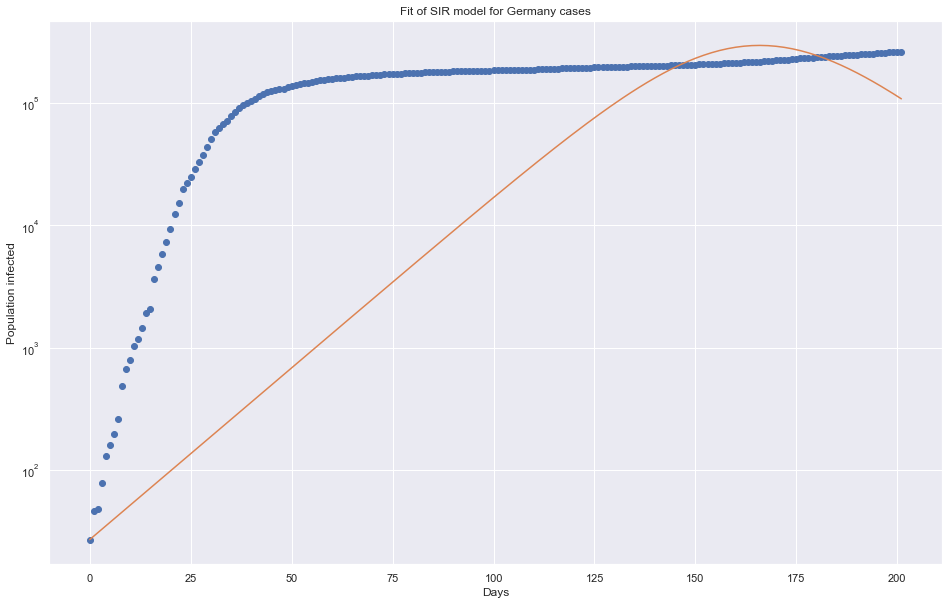

Optimal Parameters: 
beta = 0.7806427715476035  and gamma =  0.715968097516242

Basic Reproduction Number R0 =  1.0903317818988356

This ratio is derived as the expected number of new infections (these new infections are sometimes called 
secondary infections from a single infection in a population where all subjects are susceptible). @wiki


In [7]:
#Plotting the SIR model for Germany cases

plt.semilogy(t, ydata, 'o')
plt.semilogy(t, fitted)
plt.title("Fit of SIR model for Germany cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal Parameters: \nbeta =", popt[0], " and gamma = ", popt[1])
print("\nBasic Reproduction Number R0 = " , popt[0]/ popt[1])
print("\nThis ratio is derived as the expected number of new infections (these new infections are sometimes called \nsecondary infections from a single infection in a population where all subjects are susceptible). @wiki")

In [8]:
#Creating elements for Dashboard

country_list = df_analyse.columns[1:]
country_dropdown=[]
for country in country_list:
    country_dropdown.append({'label':country,'value':country})
    
ydata = df_analyse['Germany'][35:]
propagation_rates = getPropagationRates('Germany',1000000,60,70,100,100,0.2,0.1)

df_input_large=pd.read_csv('../data/processed/COVID_final_set.csv',sep=';')

1000000 24873 975127 60 70


In [34]:
#Plotting Confirmed infected vs. Dynamic parameters for SIR

sim_fig = go.Figure()
sim_fig.add_trace(go.Bar(x=np.arange(len(ydata)),
                                y=ydata, 
                                name='Confirmed infected',
                                orientation = 'v',marker_color = '#FF5959'
                                 )
                     )
sim_fig.add_trace(go.Scatter(x=t,
                                y=fitted,
                                mode='markers+lines',
                                opacity=0.9,
                                line_width=2,
                                marker_size=4,
                                marker_color = '#39F09A',
                                name='Fitted curve - Optimal beta & gamma'
                                 )
                     )
sim_fig.add_trace(go.Scatter(x=propagation_rates.index,
                                y=propagation_rates['infected'],
                                mode='markers+lines',
                                opacity=0.9,
                                line_width=2,
                                marker_size=4,
                                marker_color = '#3A37EE',
                                name='Fitted curve - all parameters'
                                 )
                     )

sim_fig.update_layout(
    xaxis_title="No. of days",
    yaxis_title="No. of cases",
    title = "Confirmed infected vs. Dynamic parameters for SIR"
)
sim_fig.update_layout(
    hoverlabel=dict(
        bgcolor="white", 
        font_size=16
    )
)
sim_fig.update_xaxes(nticks = 15,showspikes=True)
sim_fig.update_yaxes(showspikes=True,type="log")
sim_fig.show()

In [35]:
#Plotting the SIR simulations

all_sim_fig = go.Figure()
all_sim_fig.add_trace(go.Scatter(x=propagation_rates.index,
                                y=propagation_rates['susceptible'],
                                mode='markers+lines',
                                opacity=0.9,
                                line_width=2,
                                marker_size=4,
                                marker_color = 'blue',
                                name='Susceptible'
                                 )
                     )

all_sim_fig.add_trace(go.Scatter(x=propagation_rates.index,
                                y=propagation_rates['recovered'],
                                mode='markers+lines',
                                opacity=0.9,
                                line_width=2,
                                marker_size=4,
                                marker_color = 'green',
                                name='Recovered'
                                 )
                     )
all_sim_fig.add_trace(go.Scatter(x=propagation_rates.index,
                                y=propagation_rates['infected'],
                                mode='markers+lines',
                                opacity=0.9,
                                line_width=2,
                                marker_size=4,
                                marker_color = 'red',
                                name='Infected'
                                 )
                     )
all_sim_fig.update_layout(
    xaxis_title="No. of days",
    yaxis_title="Propagation rate",
    title = "SIR simulations"
)
all_sim_fig.update_layout(
    hoverlabel=dict(
        bgcolor="white", 
        font_size=16
    )
)
all_sim_fig.update_xaxes(nticks = 15,showspikes=True)
all_sim_fig.update_yaxes(showspikes=True,type="log")
all_sim_fig.show()

In [36]:
#Designing the layout of the Dashboard

app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])
app.layout = html.Div([
    html.H1('SIR Model - Dashboard Implementation', style={"textAlign":'center'}),
    html.Br(),
    html.Div([
        html.P('Select Country'),
        dcc.Dropdown(id='country_dropdown', options=country_dropdown, value ='France'),
        html.Br(),
        html.H3('Enter the Values for Parameters',style={"textAlign":'center'}),
        html.Br(),
        dbc.Form([
            dbc.Row([
                
                dbc.Col([
                    dbc.Label("Infection start (in days)"),
                    dbc.Input(id="infection_start", type="number", value=25)
                ]),
                dbc.Col([
                    dbc.Label("Intro measures start (in days)"),
                    dbc.Input(id="measures_start", type="number", value=35)
                ]),
                dbc.Col([
                    dbc.Label("Hold start (in days)"),
                    dbc.Input(id="hold_start", type="number", value=50),
                ]),
                dbc.Col([
                    dbc.Label("Relax start (in days)"),
                    dbc.Input(id="relax_start", type="number", value=50),
                    html.Br()
                    
                ]),
            ]),
            dbc.Row([
                
                dbc.Col([
                    dbc.Label("Beta value (infection rate)"),
                    dbc.Input(id="beta_value", type="number", value=0.4)
                ]),
                dbc.Col([
                    dbc.Label("Gamma value (death rate)"),
                    dbc.Input(id="gamma_value", type="number", value=0.1)
                ]),
                dbc.Col([
                    dbc.Label("Population"),
                    html.Div(id="population_div")
                ]),
                dbc.Col([
                    dbc.Label("Show simulation"),html.Br(),
                    dbc.Button("Submit", color="primary", id='submit_btn', n_clicks=0)
                ])
            ])
        ]),
        html.Div([
                dcc.Graph(figure=sim_fig, id='sim_fig_id'),
                dcc.Graph(figure=all_sim_fig, id='all_sim_fig_id')
        ])
    ])
   
],style={"marginLeft":'2%',"marginRight":'2%',"marginTop":'2%'})

In [37]:
#Defining app callbacks

@app.callback(
    Output('population_div', 'children'),
    [Input('country_dropdown', 'value')])
def update_population(country_name):
    pop = getPopulationByCountry(country_name)
    return dbc.Label(pop)


@app.callback(
    [   dash.dependencies.Output('sim_fig_id', 'figure'),
        dash.dependencies.Output('all_sim_fig_id', 'figure')],
    [
        dash.dependencies.Input('country_dropdown', 'value'),
        dash.dependencies.Input('submit_btn','n_clicks')],
    [
        dash.dependencies.State('infection_start', 'value'),
        dash.dependencies.State('measures_start', 'value'),
        dash.dependencies.State('hold_start', 'value'),
        dash.dependencies.State('relax_start', 'value'),
        dash.dependencies.State('beta_value', 'value'),
        dash.dependencies.State('gamma_value', 'value')
    ])
def update_figure(country_name,n_clicks,infection_start,measures_start,hold,relax,beta_value,gamma_value):
    country_population = getPopulationByCountry(country_name)
    ydata = np.array(df_analyse[country_name][infection_start:])
    t=np.arange(len(ydata))
    fitted,popt = fitParameters(ydata,t,country_population,beta_value,gamma_value)
    propagation_rates = getPropagationRates(country_name,country_population,infection_start,measures_start,hold,relax,beta_value,gamma_value)
    optimal = "Optimal beta("+str(popt[0])+" & gamma ("+str(popt[1])
    return {
            'data': [dict(x=t,
                                y=ydata,
                                type='bar',
                                name='Confirmed infected',
                                marker = {"color": "#f2b74b"}
                         ),
                    dict(x=propagation_rates.index,
                                y=propagation_rates['infected'],
                                mode='markers+lines',
                                opacity=0.9,
                                line_width=2,
                                marker_size=4, 
                                name='Fitted curve - all parameters', marker = {"color": "#6495ed"}),
                     dict(x=t,
                                y=fitted,
                                mode='markers+lines',
                                opacity=0.9,
                                line_width=2,
                                marker_size=4, 
                                name='Fitted curve - Optimal beta & gamma',marker = {"color": "#811331"})],
            'layout': dict (
                xaxis={'tickangle':-45,
                        'nticks':20,
                        'tickfont':dict(size=14,color="#7f7f7f"),
                        'title' : 'No. of Days'
                        
                      },
                yaxis={
                       'range':'[1.1,5.5]',
                       'title':"No. of Cases",
                       'type':'log'
                      },
                title = "Confirmed infected vs. Dynamic parameters for SIR (Optimal beta - "+str("%.2f" % popt[0])+" & gamma - "+str("%.2f" % popt[1])+")"
        )
    },{
        'data': [dict(x=propagation_rates.index,
                                y=propagation_rates['susceptible'],
                                mode='markers+lines',
                                opacity=0.9,
                                line_width=2,
                                marker_size=4, 
                                name='Susceptible', marker = {"color": "#ff6f69"}),
                    dict(x=propagation_rates.index,
                                y=propagation_rates['infected'],
                                mode='markers+lines',
                                opacity=0.9,
                                line_width=2,
                                marker_size=4, 
                                name='Infected', marker = {"color": "#50c878"}),
                     dict(x=propagation_rates.index,
                                y=propagation_rates['recovered'],
                                mode='markers+lines',
                                opacity=0.9,
                                line_width=2,
                                marker_size=4, 
                                name='Recovered',marker = {"color": "#5d3fd3"}
                         )],
            'layout': dict (
                xaxis={'tickangle':-45,
                        'nticks':20,
                        'tickfont':dict(size=14,color="#7f7f7f"),
                        'title' : 'No. of Days'
                        
                      },
                yaxis={
                       'range':'[1.1,5.5]',
                       'title':"Propagation Rates",
                       'type':'log'
                      },
                title = "Dynamic parameters with SIR"
        ) 
   }

In [38]:
app.run_server(debug=True, use_reloader=False)

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning:

overflow encountered in double_scalars

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning:

overflow encountered in double_scalars

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning:

overflow encountered in double_scalars



Standard deviation errors :  [0.01649018 0.01631242] 
Start infect: 12

Optimal parameters: 
beta = 0.6068861639196059 
gamma =  0.5447115387511431
65273511 12 65273499 25 35


/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning:

Covariance of the parameters could not be estimated



Standard deviation errors :  [inf inf] 
Start infect: 0

Optimal parameters: 
beta = 1.0 
gamma =  1.0
2722289 0 2722289 25 35
Standard deviation errors :  [inf inf] 
Start infect: 0

Optimal parameters: 
beta = 1.0 
gamma =  1.0
128932753 0 128932753 25 35
Standard deviation errors :  [inf inf] 
Start infect: 0

Optimal parameters: 
beta = 1.0 
gamma =  1.0
4822233 0 4822233 25 35
Standard deviation errors :  [inf inf] 
Start infect: 0

Optimal parameters: 
beta = 1.0 
gamma =  1.0
4822233 0 4822233 30 35
Standard deviation errors :  [0.01504577 0.01499768] 
Start infect: 75550

Optimal parameters: 
beta = 0.35719090876778337 
gamma =  0.3556456556811874
1439323776 75550 1439248226 30 35
Standard deviation errors :  [0.0171598  0.01697621] 
Start infect: 12

Optimal parameters: 
beta = 0.6205004822205672 
gamma =  0.5567600877774755
65273511 12 65273499 30 35
Standard deviation errors :  [0.00843966 0.00807396] 
Start infect: 191

Optimal parameters: 
beta = 0.5160814457817625 
gamma 